The required modules are imported: scipy.io is used to load the previously stored EMG data; numpy is used to work with arrays and matrices, as well as to use some mathematical functions; sklearn is used to perform the dimensionality reduction and scaling of the feature matrix (with the linear discriminant analysis and the min-max scaling methods, respectively) and to implement the classifier (a multiclass support vector machine); matplotlib is used to visualize data.

In [1]:
import scipy.io as sio
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
%matplotlib inline

The previously saved EMG data is loaded (in this case, data was recorded with Matlab/Simulink and stored in a .mat file. This is the reason why the scipy.io.loadmat method is used to load the data). The number of recorded gestures (nGestures), the number of EMG channels (nChannels) and the number of times each gesture was repeated (nIterations) are set.

In [2]:
emg_data = sio.loadmat('emg_data_5_class_2ch')
nGestures = 5
nChannels = 2
nIterations = 4
emg = []
segmented_emg = []

The EMG signals are stored as a list of arrays in the following manner: signals corresponding to the same motion are grouped toghether

motion1_channel1_iter1, motion1_channel2_iter1, motion1_channel1_iter2, motion1_channel2_iter2,..., motion2_channel1_iter1, motion2_channel2_iter1,...,motionM_channelC_iterI

In [3]:
for m in range(1,nGestures+1):
    for i in range(nIterations):
        for c in range(1,nChannels+1):
            emg.append(emg_data['motion'+str(m)+'_ch'+str(c)][:,i])

The raw EMG signals could be used to train the classifier, but classifiers often perform better when they are fed with a set of meaningful features that describe some properties of the data. Before computing the features of the EMG data, the signals have to be segmented, that is, they have to be divided into chunks with a predefined length. There are two methods of EMG segmentation: disjoint and overlapped segmentation [1]. The first method is implemented here with the following function.

In [4]:
def segmentation(emg, samples = 150):
    N = samples # number of samples per segment
    S = int(np.floor(emg.shape[0]/N)) # number of segments
    length = 0
    segmented_emg = np.zeros((N,S))
    for s in range(S):
        for n in range(length,N+length):
            segmented_emg[n-length,s] = emg[n] # NxS matrix with a EMG signal divided in s segments, each one with n samples
        length = length + N
    length = 0
    return segmented_emg

In [5]:
for n in range(len(emg)):
    segmented_emg.append(segmentation(emg[n]))

##Feature extraction

The features that are going to be computed are some of the time domain features described in [2]. These features are commongly used in EMG feature extraction because they are easy to compute and give meaningful information regarding the amplitude, frequency and duration of the signal.

**Mean absolute value:** it gives information about muscle contraction levels. It is defined as

\begin{equation}
MAV_{k} = \dfrac{1}{N} \sum\limits_{i=1}^{N} \vert x_{i} \vert
\end{equation}

In [6]:
def mav(segment):
    mav = np.mean(np.abs(segment))
    return mav

**Root mean square:** it reflects the mean power of the signal and is related to the constant force and non-fatiguing contraction. It is defined as

\begin{equation}
RMS_{k} = \sqrt{\dfrac{1}{N} \sum\limits_{i=1}^{N} x_{i}^{2}}
\end{equation}

In [7]:
def rms(segment):
    rms = np.sqrt(np.mean(np.power(segment,2)))
    return rms

**Variance:** it is a measure of the power density of the signal. It is defined as

\begin{equation}
VAR_{k} = \dfrac{1}{N} \sum\limits_{i=1}^{N}\left(x_{i}-\overline{x}\right)^{2}
\end{equation}

In [8]:
def var(segment):
    var = np.var(segment)
    return var

**Simple square integral:** it gives a measure of the energy of the EMG signal. It is defined as

\begin{equation}
SSI_{k} = \sum\limits_{i=1}^{N}\left(\vert x_{i}^{2} \vert\right)
\end{equation}

In [9]:
def ssi(segment):
    ssi = np.sum(np.abs(np.power(segment,2)))
    return ssi

**Zero crossings:** it is the number of times the waveform crosses zero. This feature provides an approximate estimation of frequency domain properties. The threshold avoids counting zero crossings induced by noise. It is calculated as follows

Increment one unit the zero crossings count value if

\begin{equation}
\left\lbrace x_{i} > 0 \space and \space x_{i+1} < 0 \right\rbrace \space or \space \left\lbrace x_{i} < 0 \space and \space x_{i+1} > 0 \right\rbrace \space and \space \vert x_{i} - x_{i+1} \vert \geq threshold
\end{equation}

Which can be rewritten as:

\begin{equation}
ZC_{k} = \sum\limits_{i=1}^{N-1} \left\lbrace f \left( x_{i}*x_{i+1}\right) \right\rbrace;\\
f(x) = 1, \space if \space x < 0 \space and \space \vert x_{i} - x_{i+1} \vert \geq threshold\\
f(x) = 0, \space otherwise
\end{equation}

This expression has one problem: given three consecutive data points $x_{i-1} > 0$, $x_{i} = 0$ and $x_{i+1} < 0$, the waveform has crossed zero but the zero crossing count is not incremented. If $x_{i}*x_{i+1} \leq 0$ is used instead of $x_{i}*x_{i+1} < 0$, the zero crossing is counted twice. The code that computes the zero crossings takes all this into account, and solves it by taking only the nonzero values of the segments, as shown below.

In [10]:
def zc(segment):
    nz_segment = []
    nz_indices = np.nonzero(segment)[0] #Finds the indices of the segment with nonzero values
    for m in nz_indices:
        nz_segment.append(segment[m]) #The new segment contains only nonzero values    
    N = len(nz_segment)
    zc = 0
    for n in range(N-1):
        if((nz_segment[n]*nz_segment[n+1]<0) and np.abs(nz_segment[n]-nz_segment[n+1]) >= 0.001):
            zc = zc + 1
    return zc

**Waveform length:** it is the cumulative length of the waveform over the segment. This feature is related to the signal amlitude, frequency and time. It is defined as

\begin{equation}
WL_{k} = \sum\limits_{i=1}^{N-1} \vert x_{i+1} - x_{i} \vert
\end{equation}

In [11]:
def wl(segment):
    wl = np.sum(np.abs(np.diff(segment)))
    return wl

**Slope sign changes:** it is similar to the zero crossings feature. It also provides information about the frequency content of the signal. It is calculated as follows

Increment one unit the slope sign change value if

\begin{equation}
\left\lbrace x_{i} > x_{i-1} \space and \space x_{i} > x_{i+1} \right\rbrace \space or \space \left\lbrace x_{i} < x_{i-1} \space and \space x_{i} < x_{i+1} \right\rbrace \space and \space \vert x_{i}-x_{i+1} \vert \geq threshold \space or \space \vert x_{i}-x_{i-1} \vert \geq threshold
\end{equation}

Which can be rewritten as:

\begin{equation}
SSC_{k} = \sum\limits_{i=2}^{N-1} \left[ f \left[ \left( x_{i}-x_{i-1} \right)* \left( x_{i}-x_{i+1} \right) \right] \right];\\
f(x) = 1, \space if \space x \geq threshold\\
f(x) = 0, \space otherwise
\end{equation}

In [12]:
def ssc(segment):
    N = len(segment)
    ssc = 0
    for n in range(1,N-1):
        if (segment[n]-segment[n-1])*(segment[n]-segment[n+1])>=0.001:
            ssc = ssc + 1
    return ssc

**Willison amplitude:** it is the number of times that the difference of the amplitude between to adjacent data points exceed a predefined threshold. This feature provides information about the muscle contraction level. It is defined as

\begin{equation}
WAMP_{k} = \sum\limits_{i=1}^{N-1} f(\vert x_i-x_{i+1} \vert);\\
f(x) = 1, \space if \space x \geq threshold\\
f(x) = 0, \space otherwise
\end{equation}

In [13]:
def wamp(segment):
    N = len(segment)
    wamp = 0
    for n in range(N-1):
        if np.abs(segment[n]-segment[n+1])>=50:
            wamp = wamp + 1
    return wamp

The above functions are stored in a list that is going to be executed inside a for loop.

We define a list of the different functions that compute the EMG features, to execute them one after another in a for loop.

In [14]:
feature_list = [mav, rms, var, ssi, zc, wl, ssc, wamp]

In [15]:
def features(segment,feature_list):
    features = np.zeros((1,len(segment)*len(feature_list)))
    i = 0
    for feature in feature_list:
        features[0,i] = feature(segment[0])
        features[0,i+1] = feature(segment[1])
        i = i + len(segment)
    return features

In [16]:
nSegments = len(segmented_emg[0][0])
nFeatures = len(feature_list)

feature_matrix = np.zeros((nSegments*nIterations*nGestures,nFeatures*nChannels))
n = 0

for i in range(0,len(segmented_emg),nChannels):
    for j in range(nSegments):
        feature_matrix[n] = features((segmented_emg[i][:,j],segmented_emg[i+1][:,j]),feature_list)
        n += 1

##Dimensionality reduction and feature scaling

In [17]:
def feature_scaling(feature_matrix,target,reductor=None,scaler=None):
    lda = LDA(n_components=2)    
    minmax = MinMaxScaler(feature_range=(-1,1))
    if not reductor:
        reductor = lda.fit(feature_matrix,target)
    feat_lda = reductor.transform(feature_matrix)
    if not scaler:
        scaler = minmax.fit(feat_lda)
    feat_lda_scaled = scaler.transform(feat_lda)
    
    return feat_lda_scaled,reductor,scaler

In [18]:
def gestures(nSamples,nGestures):
    gestures = []
    for m in range(nGestures):
        gestures.append((m*np.ones((nSamples))))
    gestures = np.array(gestures).ravel()
    return gestures

In [19]:
y = gestures(nIterations*nSegments,nGestures)
[X,reductor,scaler] = feature_scaling(feature_matrix, y)

At this point, the feature matrix can be visualized in a scatter plot.

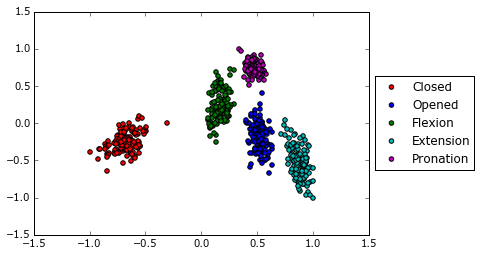

In [20]:
plt.scatter(X[0:nSegments*nIterations,0],X[0:nSegments*nIterations,1],c='r',label='Closed')
plt.scatter(X[nSegments*nIterations:2*nSegments*nIterations,0],X[nSegments*nIterations:2*nSegments*nIterations,1],c='b',label='Opened')
plt.scatter(X[2*nSegments*nIterations:3*nSegments*nIterations,0],X[2*nSegments*nIterations:3*nSegments*nIterations,1],c='g',label='Flexion')
plt.scatter(X[3*nSegments*nIterations:4*nSegments*nIterations,0],X[3*nSegments*nIterations:4*nSegments*nIterations,1],c='c',label='Extension')
plt.scatter(X[4*nSegments*nIterations:5*nSegments*nIterations,0],X[4*nSegments*nIterations:5*nSegments*nIterations,1],c='m',label='Pronation')
plt.legend(scatterpoints=1,loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#plt.scatter(feat_scaled[:,0],feat_scaled[:,1],c=target)
#plt.show()

Five distinct point clusters, corresponding to the five recorded gestures, can be seen. With these data, the classifier will not have any problem in computing the decision boundaries, and probably the classification accuracy will be near a 100%.

##Classification

In [21]:
classifier = SVC(kernel='rbf',C=100,gamma=1)
classifier.fit(X, y)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Test the classifier. We take the last iteration of each recorded gesture. We execute the same steps to have the scaled feature matrix (segmentation -> feature calculation -> target matrix generation -> feature scaling)

In [22]:
emg_test = []
segmented_emg_test = []

for m in range(1,nGestures+1):
    for c in range(1,nChannels+1):
        emg_test.append(emg_data['motion'+str(m)+'_ch'+str(c)][:,4]) #motion1_ch1_i1, motion1_ch2_i1, motion1_ch1_i2, motion1_ch2_i2

for n in range(len(emg_test)):
    segmented_emg_test.append(segmentation(emg_test[n]))

nIterations = 1 #To test the classifier, the last iteration of each gesture is used
nSegments = len(segmented_emg_test[0][0])

feature_matrix_test = np.zeros((nSegments*nIterations*nGestures,nFeatures*nChannels))
n = 0

for i in range(0,len(segmented_emg_test),nChannels):
    for j in range(len(segmented_emg_test[0][0])):
        feature_matrix_test[n] = features((segmented_emg_test[i][:,j],segmented_emg_test[i+1][:,j]),feature_list)
        n = n + 1

y_test = gestures(nSegments,nGestures)

[X_test,reductor,scaler] = feature_scaling(feature_matrix_test,y_test,reductor,scaler)

In [23]:
predict = classifier.predict(X)
print("Classification accuracy = %0.2f percent." %(100*classifier.score(X_test,y_test)))

Classification accuracy = 98.75 percent.


As expected, the achieved classification accuracy is very high, near a perfect score.

##References

[1] M.A. Oskoei and H. Hu. Support vector machine-based classification scheme for myoelectric control applied to
upper limb. *IEEE Transactions on Biomedical Engineering*, 55(8):1956–1965, 2008.